In [4]:
import os
import numpy as np
import pandas as pd
import uproot as ur

import sys
sys.path.append('../..')
from jupyter_utils import *

from matplotlib import pyplot as plt
from IPython.display import Image
pd.set_option('display.max_columns', None) # to see all columns of df.head()
pd.set_option('display.max_rows', None)

# Lauren's colors
L_colors = ['red', 'darkorange', 'limegreen', 'green', 'deepskyblue', 'blue', 'black']
L_linestyles = ['solid', 'dashed']

In [39]:
# trk and jet pt bins
trk_pt_lo = [1, 2, 4, 7]
trk_pt_hi = [2, 4, 7, 20]

jet_pt_lo = [40, 50, 60]
jet_pt_hi = [50, 60, 70]
jet_pt_sel = 2


In [32]:
# file defs

base_dir = "/global/cfs/cdirs/alice/kdevero/"
fs = [base_dir+"PbPb_jet-trk/20716692/merged.root"]
f_names = ["Pb+Pb, 0-10%"]
#fs = ["./output_data/rhooff/merged.root", "./output_data/rhoon/merged.root"]
#f_names = ["Pb+Pb, rho off", "Pb+Pb, rho on"]


n_jetpt = "h_jet_pt_JetPt_R0.4_0.15"
n_shape_pt = "h_jet-trk_shape_RL_TrkPt_JetPt_R0.4_0.15"
n_shape_z = "h_jet-trk_shape_RL_z_JetPt_R0.4_0.15"
n_ptprofile_pt = "h_jet-trk_ptprofile_RL_TrkPt_JetPt_R0.4_0.15"
n_ptprofile_z = "h_jet-trk_ptprofile_RL_z_JetPt_R0.4_0.15"


Njets : 32708.0
Njets : 5115.0
Njets : 830.0


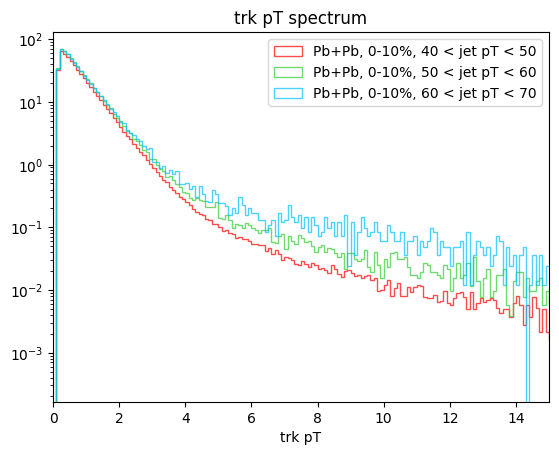

In [33]:
for fi in range(len(fs)):
    f = ur.open(fs[fi])
    
    for jetpti in range(len(jet_pt_lo)):
        
        h = f[n_jetpt]
        h_jetpt = h.to_numpy()[0]
        pt_range = (findbin(h.axis("x"), jet_pt_lo[jetpti]), findbin(h.axis("x"), jet_pt_hi[jetpti]))
        h_jetpt = h_jetpt[pt_range[0]:pt_range[1]]
        N_jets = np.sum(h_jetpt)
        print("Njets : " + str(N_jets))

        h = f[n_shape_pt]
        bin_edges = h.axis("y").edges()
        bin_width = bin_edges[1] - bin_edges[0]
        
        h_numpy = h.to_numpy()[0]
        pt_range = (findbin(h.axis("z"), jet_pt_lo[jetpti]), findbin(h.axis("z"), jet_pt_hi[jetpti]))
        h_numpy = zslice(h_numpy, pt_range[0], pt_range[1])
        
        this_slice = projectionY(h_numpy)
        this_slice = this_slice / (bin_width * N_jets)
        plt.hist(bin_edges[:-1], bin_edges, weights=this_slice, lw=1, histtype = 'step', alpha=0.7, fill=False, linestyle=L_linestyles[fi], color=L_colors[2*jetpti], label=f_names[fi] + ", " + str(jet_pt_lo[jetpti]) + " < jet pT < " + str(jet_pt_hi[jetpti]))
    

plt.legend()
plt.title("trk pT spectrum") 
plt.xlabel('trk pT')
plt.xlim(0, 15)
#plt.ylim(1, 10)
#plt.xscale('log')
plt.yscale('log')
plt.show()



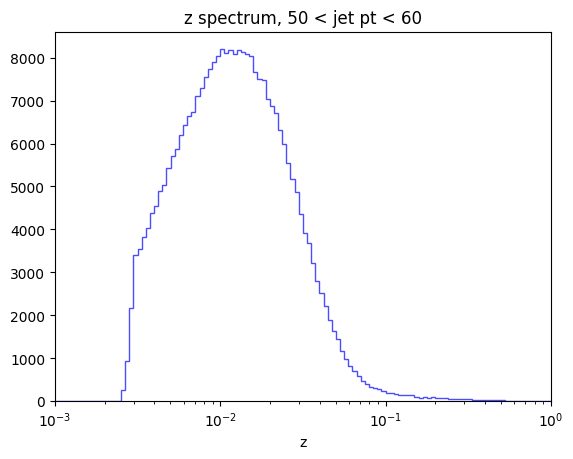

In [34]:
for fi in range(len(fs)):
    f = ur.open(fs[fi])
    
    h = f[n_shape_z]
    bin_edges = h.axis("y").edges()
    bin_width = bin_edges[1] - bin_edges[0]
    
    h_numpy = h.to_numpy()[0]
    pt_range = (findbin(h.axis("z"), jet_pt_lo[jet_pt_sel]), findbin(h.axis("z"), jet_pt_hi[jet_pt_sel]))
    h_numpy = zslice(h_numpy, pt_range[0], pt_range[1])
        
    this_slice = projectionY(h_numpy)
    plt.hist(bin_edges[:-1], bin_edges, weights=this_slice, lw=1, histtype = 'step', alpha=0.7, fill=False, color="blue")
    
    plt.title("z spectrum, {} < jet pt < {}".format(jet_pt_lo[jet_pt_sel], jet_pt_hi[jet_pt_sel]) )
    plt.xlabel('z')
    plt.xlim(1e-3, 1)
    plt.xscale('log')
    #plt.yscale('log')
    plt.show()
    

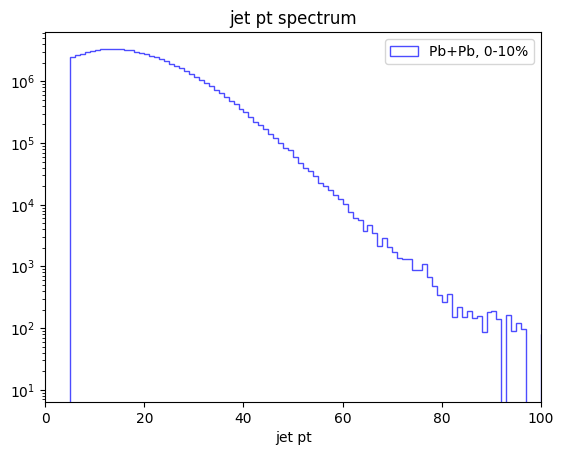

In [35]:
for fi in range(len(fs)):
    f = ur.open(fs[fi])
    
    h = f[n_shape_z]
    bin_edges = h.axis("z").edges()
    bin_width = bin_edges[1] - bin_edges[0]
    h_numpy = h.to_numpy()[0]
    this_slice = projectionZ(h_numpy)
    plt.hist(bin_edges[:-1], bin_edges, weights=this_slice, lw=1, histtype = 'step', alpha=0.7, fill=False, color="blue", linestyle=L_linestyles[fi], label=f_names[fi])
    
    plt.legend()
    plt.title("jet pt spectrum") 
    plt.xlabel('jet pt')
    plt.xlim(0, 100)
    #plt.xscale('log')
    plt.yscale('log')
plt.show()
    

In [40]:
# find number of jets in selected jet pt bin

N_jets = []

for f in fs:
    f = ur.open(f)
    h = f[n_jetpt]
    h_jetpt = h.to_numpy()[0]
    pt_range = (findbin(h.axis("x"), jet_pt_lo[jet_pt_sel]), findbin(h.axis("x"), jet_pt_hi[jet_pt_sel]))
    h_jetpt = h_jetpt[pt_range[0]:pt_range[1]]
    N_jets.append(np.sum(h_jetpt))

print("Njets : " + str(N_jets))


Njets : [830.0]


(10, 20)
10461.0
(20, 40)
3122.0
(40, 70)
593.0
(70, 200)
565.0


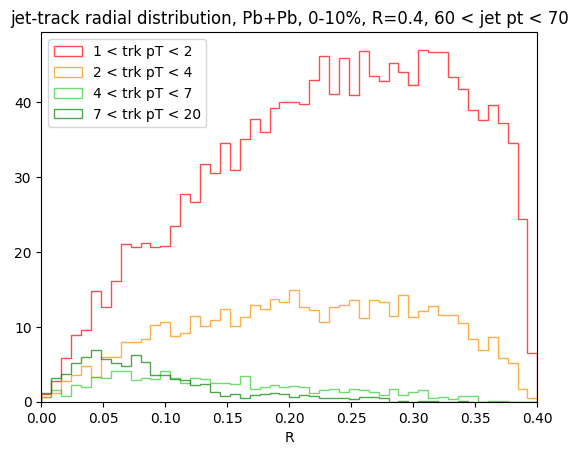

In [42]:
hs = []

for fi in range(len(fs)):
    f = ur.open(fs[fi])
    h = f[n_shape_pt]
    bin_edges = h.axis("x").edges()
    bin_width = bin_edges[1] - bin_edges[0]
    
    h_numpy = h.to_numpy()[0]
    pt_range = (findbin(h.axis("z"), jet_pt_lo[jet_pt_sel]), findbin(h.axis("z"), jet_pt_hi[jet_pt_sel]))
    h_numpy = zslice(h_numpy, pt_range[0], pt_range[1])
    
    integrals = []
    h_trk = []
    for i in range(len(trk_pt_lo)):
        trk_pt_range = (findbin(h.axis("y"), trk_pt_lo[i]), findbin(h.axis("y"), trk_pt_hi[i]))
        print(trk_pt_range)

        this_slice = yslice(h_numpy, trk_pt_range[0], trk_pt_range[1])
        print(np.sum(this_slice))
        this_slice = this_slice / (N_jets[fi] * bin_width)

        plt.hist(bin_edges[:-1], bin_edges, weights=this_slice, lw=1, histtype = 'step', alpha=0.7, fill=False, linestyle=L_linestyles[fi], color=L_colors[i], label='{} < trk pT < {}'.format(trk_pt_lo[i], trk_pt_hi[i]))
        h_trk.append(this_slice)
    hs.append(h_trk)

    plt.legend(loc='upper left')
    plt.title("jet-track radial distribution, " + f_names[fi] + ", R=0.4, {} < jet pt < {}".format(jet_pt_lo[jet_pt_sel], jet_pt_hi[jet_pt_sel])) 
    plt.xlabel('R')
    plt.xlim(0, 0.4)
    #plt.ylim(0, 0.5)

plt.show()

[     0.            338.99261929   1330.20771111   3053.27076916
   5149.94862641   7814.02708032  10652.29293265  14294.83076391
  17708.13932022  21541.73292635  25562.63250387  30128.99977196
  34910.36559468  39715.32435855  44687.53322654  49815.68430643
  54903.82405378  60464.30681402  66233.8015581   71934.10254646
  77800.92951458  83990.87798849  90309.75747817  96619.3481633
 103024.84367732 109723.74132178 116683.37800944 123510.42515869
 130469.66707252 137520.40206749 144365.63785735 151418.48311316
 158553.8181407  165746.34334426 173184.43439196 180494.33059504
 187707.38918079 194727.35737077 201590.23783823 208438.47469776
 215164.51967517 221788.6131453  228341.27274381 234684.73149444
 240799.74539973 246643.10787288 252127.84301294 257226.0717138
 261667.17196264]


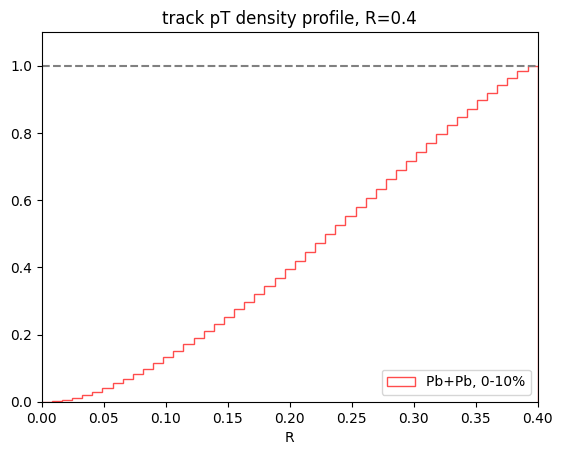

In [19]:
hs = []
for i in range(len(fs)):
    f = ur.open(fs[i])
    h = f[n_ptprofile_pt]
    
    h_numpy = h.to_numpy()[0]
    pt_range = (findbin(h.axis("z"), jet_pt_lo[jet_pt_sel]), findbin(h.axis("z"), jet_pt_hi[jet_pt_sel]))
    h_numpy = projectionX(zslice(h_numpy, pt_range[0], pt_range[1]))

    n_r_bins = 50
    bin_edges = np.linspace(0, 0.4, n_r_bins)
    bin_widths = 0.4 / n_r_bins
    
    h_to_graph = np.array([np.sum(h_numpy[0:findbin(h.axis("x"), bin_edges[i])]) for i in range(n_r_bins-1)])
    print(h_to_graph)
    
    # normalization by inclusive RL selection
    h_to_graph = h_to_graph / h_to_graph[len(h_to_graph)-1]
    hs.append(h_to_graph)
    
    plt.hist(bin_edges[:-1], bin_edges, weights=h_to_graph, lw=1, histtype = 'step', alpha=0.7, fill=False, color=L_colors[3*i], label=f_names[i])
    
plt.axhline(1, linestyle='--', color='gray')
plt.legend(loc='lower right')
plt.title("track pT density profile, R=0.4") 
plt.xlabel('R')
plt.xlim(0, 0.4)
plt.ylim(0, 1.1)
plt.show()


(10, 20)
(10, 40)
(10, 70)
(10, 200)


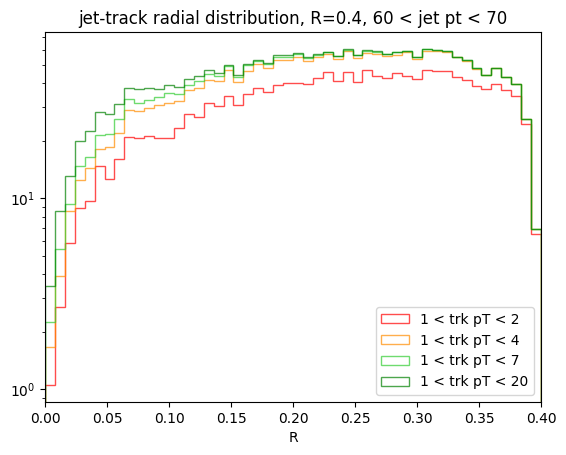

In [48]:
f = ur.open(fs[0])
h = f[n_shape_pt]
bin_edges = h.axis("x").edges()
bin_width = bin_edges[1] - bin_edges[0]

h_numpy = h.to_numpy()[0]
pt_range = (findbin(h.axis("z"), jet_pt_lo[jet_pt_sel]), findbin(h.axis("z"), jet_pt_hi[jet_pt_sel]))
h_numpy = zslice(h_numpy, pt_range[0], pt_range[1])

for i in range(len(trk_pt_lo)):
    trk_pt_range = (findbin(h.axis("y"), trk_pt_lo[0]), findbin(h.axis("y"), trk_pt_hi[i]))
    print(trk_pt_range)
    
    this_slice = yslice(h_numpy, trk_pt_range[0], trk_pt_range[1])
    this_slice = this_slice / (N_jets[fi] * bin_width)
    
    plt.hist(bin_edges[:-1], bin_edges, weights=this_slice, lw=1, histtype = 'step', alpha=0.7, fill=False, color=L_colors[i], label='{} < trk pT < {}'.format(trk_pt_lo[0], trk_pt_hi[i]))
    
plt.legend(loc='lower right')
plt.title("jet-track radial distribution, R=0.4, {} < jet pt < {}".format(jet_pt_lo[jet_pt_sel], jet_pt_hi[jet_pt_sel])) 
plt.xlabel('R')
plt.yscale("log")
plt.xlim(0, 0.4)
#plt.ylim(5e2, 2e5)
plt.show()

(10, 20)
(20, 40)
(40, 70)
(70, 200)


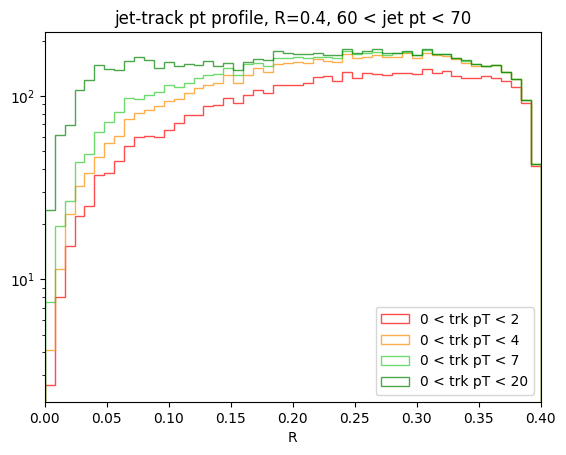

In [43]:
f = ur.open(fs[0])
h = f[n_ptprofile_pt]
bin_edges = h.axis("x").edges()
bin_width = bin_edges[1] - bin_edges[0]

h_numpy = h.to_numpy()[0]
pt_range = (findbin(h.axis("z"), jet_pt_lo[jet_pt_sel]), findbin(h.axis("z"), jet_pt_hi[jet_pt_sel]))
h_numpy = zslice(h_numpy, pt_range[0], pt_range[1])

for i in range(len(trk_pt_lo)):
    trk_pt_range = (findbin(h.axis("y"), trk_pt_lo[i]), findbin(h.axis("y"), trk_pt_hi[i]))
    print(trk_pt_range)
    
    this_slice = yslice(h_numpy, 0, trk_pt_range[1])
    this_slice = this_slice / (N_jets[fi] * bin_width)
    
    plt.hist(bin_edges[:-1], bin_edges, weights=this_slice, lw=1, histtype = 'step', alpha=0.7, fill=False, color=L_colors[i], label='{} < trk pT < {}'.format(0, trk_pt_hi[i]))
    
plt.legend(loc='lower right')
plt.title("jet-track pt profile, R=0.4, {} < jet pt < {}".format(jet_pt_lo[jet_pt_sel], jet_pt_hi[jet_pt_sel])) 
plt.xlabel('R')
plt.yscale("log")
plt.xlim(0, 0.4)
#plt.ylim(5e2, 2e5)
plt.show()
